In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from tqdm import tqdm
from scipy.linalg import eigvals
from scipy.stats import laplace
from scipy.stats import multivariate_normal
from scipy.special import expit 
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap

# 1. Bayesian Logistic Regression with Laplace prior

Dans cette section, nous appliquons la Stochastic Gradient Langevin Dynamics afin d'effectuer une Bayesian Logistic Regression avec une prior de Laplace de scale $b=1$.  
On rappelle le modèle:

- $p(\beta) \sim \mathcal{L}(0, 1)$ i.e $p(\beta) \propto \exp(-\|\beta\|_1)$,

- $ \forall i \in \{1, ..., N\}, y_i \sim \mathcal{B}\left(\sigma(\beta^{\top}x_i)\right)$ i.i.d, où $\sigma$ est la fonction sigmoïde. En utilisant la propriété $\forall z \in \mathbb{R}, \sigma(-z) = 1 - \sigma(z)$ on peut écrire: $\forall i \in \{1, ..., N\}, p(y_i | \beta, x_i) = \sigma(y_i \cdot \beta^{\top}x_i)$.

On a alors $\log p(\beta | X, y) \propto_+  \sum_{i=1}^N \log \sigma(y_i \cdot \beta^{\top}x_i) - \| \beta \|_1$.

On peut alors écire un sub-gradient de la log-posterior en utilisant le fait que $\forall z \in \mathbb{R}, \sigma'(z) = (1 - \sigma(z)) \cdot \sigma(z)$ et qu'un subgradient de la log-prior est $\partial_{\beta} \log p(\beta) = - \frac{1}{2} \mathrm{sign}(\beta)$: 
$ \partial_{\beta} \log p(\beta | X, y) = \sum_{i=1}^N y_i \cdot x_i \left( 1 - \sigma(y_i \cdot \beta^{\top}x_i) \right) - \mathrm{sign}(\beta)$.

## 1.1 Stochastic Gradient Langevin Dynamics

Cette méthode a pour but d'allier **optimisation** (SGD) et **échantillonnage** (Langevin) en **une seule et unique méthode** afin d'étendre les méthodes bayésiennes aux cas de grands datasets.   

Sa grande force (mais qui fait aussi sa faiblesse, nous y reviendrons...) est qu'elle permet à la façon d'une méthode de Robbin-Monroe d'échantillonner sans avoir à effectuer un calcul à partir du dataset entier. La **SGLD** utilise les données  par **batch**, contrairement à la **majorité** des méthodes **MCMC** qui utilisent **tout le training set**. Par exemple, une symetric random walk nécéssite à chaque itération de calculer la probabilité d'acceptation du candidat, qui est un rapport de densité ($\alpha = \mathrm{min}(1, \pi(\theta_t) \, / \, \pi(\tilde{\theta}_t))$ où $\pi$ est notre loi cible, en l'occurence la posterior sur les paramètres dans le cadre bayésien). Ceci peut donc s'avérer extrêmement couteux lorsque le nombre de points dans le dataset est important. 

Dès lors que la phase d'**optimisation** est terminée, i.e que l'on se stabilise dans un zone de forte probabilité de la posterior (attention, pas necessairement dans un unique mode, l'idéee est d'explorer des zones de forte probabilités autre que le mode donné par le MAP uniquement), l'algorithme **échantillonne** selon cette loi. Comme avec toute méthode MCMC, le théorème ergodique nous permet de calculer d'approximer des calculs d'éspérance et donc de **predictive distribution**.

### 1.1.1 A brief summary of the method

#### An iteration

En exploitant les calculs précédents, l'itération $t$ de la **SGLD** s'écrit:

- Selectionner un batch $B_t = \{x_{1}, ..., x_{n}\}$ et calculer la step-size $\epsilon_t = a \cdot (b+t)^{-\gamma}$

- Échantilloner $\eta_t \sim \mathcal{N}(0,\epsilon_t \cdot I)$

- Mettre à jour $\beta_{t+1} \leftarrow \beta_t - \frac{1}{2} \epsilon_t \cdot \left[ \frac{N}{n} \sum_{i=1}^n y_i \cdot x_i \left( 1 - \sigma(y_i \cdot \beta^{\top}x_i) \right) -  \mathrm{sign}(\beta)\right] - \eta_t$

#### Optimisation (SGD) and Sampling phase (Langevin)

Il est peut être assez difficile d'estimer précisemment le **début** de la phase d'**échantillonnage** sans avoir à calculer la posterior à chaque itération, ce qui ferait perdre à la méthode toute son utilité puisqu'on devrait calculer une quantité nécessitant le traitement du dataset entier. De plus, cette estimation est très importante dans le mesure où l'inclusion d'échantillon de la phase d'optimisation dans les **calculs d'éspérances** biaserait fortement ces derniers.

L'article fournit une méthode **empirique** d'estimation du début de la phase de sampling. 

#### Predictive distribution 

En utilisant les échantillons fournis par l'algorithme et en fixant un seuil $t_0$ (burn-in) à partir duquel on suppose être dans la phase de sampling (i.e en supposant que $(\beta_t)_{t\in\{t_0, ..., T\}}$ sont distribués selon la posterior, on peut approximer la **predictive distribution** du label $y^*$ d'un **nouvel échantillon** $x^*$ par **Monte Carlo**: $p(y^* | x^*, X, y) = \mathbb{E}_{p(\beta|X,y)}\left[\, p(y^*|\beta,x^*)\, \right] \approx \frac{1}{T-t_0} \sum_{i=t_0}^T p(y^*|\beta_t, x^*)$.  
On obtient alors, pour $x^*$ un nouvel échantillon: $p(y^*=1|x^*, X, y) \approx \frac{1}{T-t_0} \sum_{t=t_0}^T \sigma(\beta_t^{\top} x^*)$. 

De plus, il est interessant de préciser que l'article suppose une autre façon de calculer des éspérances selon la posterior en utilisant les step-sizes calulées à chaque itération et approximer: $\mathbb{E}_{p(\beta|X,y)}\left[p(y^*|\beta,x^*)\, \right] \approx \frac{1}{T-t_0} \sum_{t=t_0}^T  \epsilon_t \, p(y^*|\beta_t, x^*) \, / \, \sum_{t=t_0}^T \epsilon_t$.  
L'idée est de contrer le fait que les step-sizes $\epsilon_t {\rightarrow 0}$ quand $t \rightarrow \infty$ donc le **taux de mélange** de la chaîne de markov diminue et les échantillons deviennent de **plus en plus corrélés** à mesure que l'on échantillonne. On **pondère** ainsi la contribution de chaque échantillon à l'approximation de l'éspérance en fonction de la step-size correspondante. Comme $\sum_{t} \epsilon_t = \infty$, cet estimateur de l'éspérance est toujours consistant.

#### Predictions and benefits of Bayesian methods

Si l'on veut faire de la "hard-classification", on peut alors prédire $\hat{y}^* = \mathbb{1}_{\{p(y^*=1|x^*, X, y) \geq p_0\}}$ où $p_0$ est une probabilité de seuil qui peut être optimiser selon les types de métriques que l'on veut optimiser (precision, recall, accuracy...). Toutefois, l'intérêt majeur de cette méthode est qu'elle permet d'estimer **l'incertitude** et donc la **robustesse** de notre **prédiction**, ce qui est fondamental dans de nombreux domaines (médical, contrôle...). 

Il est vrai qu'une **logistic regression classique** fourni par le biais de la likelihood de bernouilli une estimation de la probabilité de la classe d'un nouvel échantillon sachant le paramètre: $p(y^* | x^*, \hat{w}) = \sigma(x^* {\top} \hat{w})$ où $\hat{w}$ peut être l'estimateur MAP ou ML du paramètre.  
En revanche, il a été montré dans cet article: On calibration of modern neural networks [Guo et al., 2017] Guo, C., Pleiss, G., Sun, Y., and Weinberger, K. Q. (2017), que ce type de classifieurs sont **sur-confiants**. Cet article traite de réseaux de neurones mais la logistic-regression (binary ou multiclass) est un cas particulier simple de réseau de neurone utilisant des couches finales de type sigmoïde ou softmax.. Par exemple, s'ils prédisent $p(y^* = 1 | x^*, \hat{w}) = 0.9$, cette prédicion ne s'avère pas vrai dans 90% des cas, comme ce suggéré par cete probabilité. En revanche, les **méthodes bayésiennes** fournissent par le biais de la predictive distribution une **estimation** bien plus **effective** de l'**incertitude** sur la prédiction.

### 1.1.2 Implementation

In [205]:
def get_step_size(a, b, gamma, t):
    """
    Get the step size for parameters (a, b, gamma) at iteration t.
    Arguments:
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      t: int, iteration number
    Return:
      float, step_size
    """
    return a * (b + t) ** (- gamma)

def post_laplace(beta, X, y):
    """
    Evaluate the (unormalized) posterior over the whole training set in beta.
    For numerical stability, prefer np.exp(log_post_laplace(beta, X, y)) to compute posterior pdf.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples 
      y: np.array, training labels 
    Return:
      float, (unormalized) posterior evaluated in beta
    """
    return np.product(expit(y * (X @ beta))) * np.exp(- np.linalg.norm(beta, ord=1))

def log_post_laplace(beta, X, y):
    """
    Evaluate the (unormalized) log-posterior over the whole training set in beta.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples 
      y: np.array, training labels 
    Return:
      float, (unormalized) log-posterior evaluated in beta
    """
    return (np.log(expit(y * (X @ beta)))).sum(axis=0) - np.linalg.norm(beta, ord=1)

def gradient_laplace(beta, batch_X, batch_y, n_samples, bool_cov_score=False):
    """
    Get a sub-gradient of the log-posterior w.r.t beta for a given batch.
    Arguments:
      beta: np.array, parameter of logistic regression
      batch_X: np.array, batch of training examples 
      y: np.array, labels of training examples in the batch
      n_samples, int, number of samples in the training set
      bool_cov_score: boolean, if True compute the covariance of the score (to estimate the beginning of the sampling phase)
    Return:
      batch_grad: np.array, sub-gradient of the log-posterior w.r.t beta for the given batch
      cov_score: np.array, empirical covariance of the score (score = partial gradient for each sample in the batch + 1/n_samples sub-gradient of the prior)
    """
    # get batch gradient 
    res = (expit(- batch_y * (batch_X @ beta)) * batch_y)[:, None] * batch_X
    batch_grad = (n_samples / len(batch_X)) * res.sum(axis=0) - np.sign(beta)
    if bool_cov_score==False:
        return batch_grad
    
    # get empirical covariance of the score if required
    else:
        # get score 
        res2 = res - (1/n_samples) * np.sign(beta)
        # get empirical covariance
        cov_score = (1 / len(batch_X)) * (res2 - res2.sum(0)).T @ (res2 - res2.sum(0))
        return batch_grad, cov_score 

def SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackW=False, bool_trackL=False, bool_trackA=False):
    """
    SGLD for Bayesian Logistic Regression with Laplace Prior.
    Arguments:
      X: np.array,  training examples 
      y: np.array, training labels
      n_iter: int, number of iterations
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      beta_0: np.array, initial beta 
      batch_size: int, size of the batch 
      bool_trackL: boolean, if True compute and return the log-posterior at each step (costly: require a pass over the whole training set)
      bool_weights: boolean, if True return the weights at each iteration to compute posterior expectation (as proposed in the article)
      bool_trackA: boolean, if True compute and return the alpha to evaluate begining of the sampling phase (see article for expression)
    Return:
      tackL: np.array, log-posterior evaluate at each step
      betas: np.array, paremeters at each step
    """
    start = time.time()
    N, dim = X.shape
    beta = beta_0
    betas = np.concatenate((beta[None, :], np.zeros((n_iter, dim))), axis=0)
    
    # compute and store log-posterior throughout the iterations if required
    if bool_trackL: 
        trackL = np.concatenate(([log_post_laplace(beta, X, y)], np.zeros(n_iter)))
        
    # store weights throughout the iterations if required
    if bool_trackW:
        trackW = np.zeros(n_iter)
    
    # store weights throughout the iterations if required
    if bool_trackA:
        trackA = np.zeros(n_iter)
    
    for ii in tqdm(range(n_iter)):
                
        # select a batch of size batch_size
        idxs = np.random.choice(N, size=batch_size)
        batch_X = X[idxs]
        batch_y = y[idxs]
        
        ### STEP 1: ###
        # compute step size 
        step_size = get_step_size(a, b, gamma, t=ii)
        
        ### STEP 2: ###
        # sample noise
        eta = multivariate_normal.rvs(mean=np.zeros(2), cov=step_size*np.eye(dim))
        
        ### STEP 3: ###
        # update and store parameter
        if bool_trackA:
            grad, cov_score = gradient_laplace(beta, batch_X, batch_y, n_samples=N, bool_cov_score=True)
        else:
            grad = gradient_laplace(beta, batch_X, batch_y, n_samples=N)
        beta = beta + (step_size / 2) * grad + eta 
        betas[ii+1] = beta
        
        # compute and store log-posterior if required
        if bool_trackL:
            trackL[ii+1] = log_post_laplace(beta, X, y)
            
        # store weights if required
        if bool_trackW:
            trackW[ii] = step_size
            
        # compute and store alpha if required
        if bool_trackA:
            trackA[ii] = ((step_size * N**2) / (4 * len(batch_X))) * np.amax(np.real(eigvals(cov_score)))
            
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    if bool_trackA & bool_trackW & bool_trackL:
        return betas,trackA, trackW, trackL
    if bool_trackA & bool_trackW: 
        return betas, trackA, trackW
    if bool_trackA & bool_trackL: 
        return betas, trackA, trackL
    if bool_trackW & bool_trackW: 
        return betas, trackW, trackL
    if bool_trackA:
        return betas, trackA 
    if bool_trackW:
        return betas, trackW
    if bool_trackL:
        return betas, trackL
    else:
        return betas
    
    
def predictive_MC(X_new, samples, burn_in=None, weights=None):
    """
    Get the predictive distribution by Monte-Carlo approximation.
    Arguments:
      X_new: np.array, new unseen examples
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
      weights: np.array, weights to compute expectation (if None: uniform weights)
    Return:
      np.array, predictive distribution
    """
    if burn_in==None:
        burn_in=0
    if np.all(weights)==None:
        return expit(X_new @ samples[burn_in+1:].T).mean(1) 
    else:
        return (weights[None, burn_in:] * expit(X_new @ samples[burn_in+1:].T)).sum(1) / weights[burn_in:].sum()

### 1.1.3 Application on a toy dataset

Dans cette section, on teste notre implémentation de la SGLD sur un dataset linéairement séparable dans $\mathbb{R}^2$.  

Notons qu'afin d'avoir une posterior $p(\beta | X, y)$ facilement visualisable par des contour-plots, on considère un dataset linéairement séparable dont un hyperplan séparateur passe par l'origine $(0, 0)$ afin que nous n'ayons pas à inclure de biais et donc d'avoir une posterior définie sur $\mathbb{R}^2$.

#### Dataset visualization

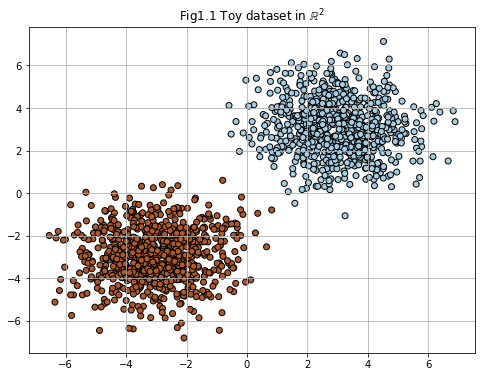

In [217]:
# load linearly separable dataset
X, y = make_blobs(n_samples=1500, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Fig1.1 Toy dataset in $\mathbb{R}^2$")
plt.grid()
plt.show()

#### Running time

Examinons brièvement le temps de calcul pour ce dataset simple, selon si l'on met à jour uniquuement les paramètres ou si l'on calcule en plus la log-posterior où les $\alpha$ à chauqe itération.

Dans le cas où les poids sont stockés à chaque étape, ce sont uniquement des flottants stockés dans un array de taille fixé où l'allocation mémoire est déja pré-effectuée lors de l'initialisation `trackW = np.zeros(n_iter)`, ce n'est donc absolument pas couteux. Il n'est donc pas nécessaire de s'intéresser au temps de calcul lorsque l'on stocke les poids à chaque étape.

In [287]:
a = 1
b = 20
gamma = .6
batch_size = 5
beta_0 = np.random.rand(X.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
_ = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size)

# computing log-posterior at each step  
print(f"\nComputing just the log-posterior at each step:")
time.sleep(1)
betas, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# computing alphas at each step  
print(f"\nComputing just the alphas at each step:")
time.sleep(1)
betas, trackA = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# computing both alphas and log-posterior at each step  
print(f"\nComputing both the log-posterior and the alphas at each step:")
time.sleep(1)
betas, trackA, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:00<00:00, 6110.28it/s]


Done in 0.82 s.

Computing just the log-posterior at each step:


100%|██████████| 5000/5000 [00:00<00:00, 5422.54it/s]


Done in 0.92 s.

Computing just the alphas at each step:


100%|██████████| 5000/5000 [00:00<00:00, 5675.25it/s]


Done in 0.88 s.

Computing both the log-posterior and the alphas at each step:


100%|██████████| 5000/5000 [00:01<00:00, 3686.95it/s]


Done in 1.36 s.


#### Examination of the convergence

In [219]:
a = 1
b = 20
gamma = .6
batch_size = 5
beta_0 = np.ones(X.shape[1])
n_iter = 5000

# computing both alphas and log-posterior at each step  
print(f"\nComputing both thelog-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackA, trackW, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True, bool_trackW=True)


Computing both thelog-posterior, the alphas and storing the weights at each step:


100%|██████████| 5000/5000 [00:01<00:00, 4019.33it/s]


Done in 1.25 s.


Vérifions alors que l'on optimise bien la log-posterior puis que l'on échantillonne selon la posterior. On devrait observer deux phases:

- une phase où la log-posterior croît rapidement (optimisation phase: SGD),

- une phase où l'algorithme se stabilise dans un mode la posterior distribution et échantillonne (sampling phase: Langevin).

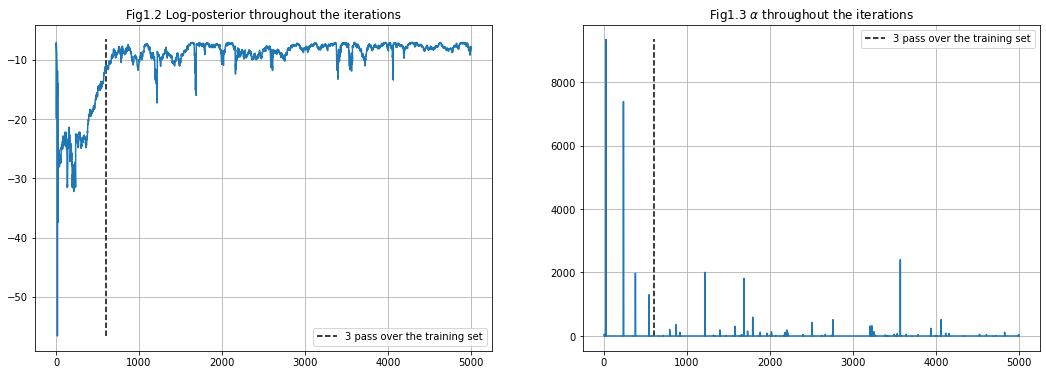

In [220]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))

# plot log-posterior 
ax[0].vlines(3*1000/(batch_size), ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{3} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Fig1.2 Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(3*1000/(batch_size), ymin=trackA.min(), ymax=trackA.max()+.5, ls='--', color='k', label=f'{3} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("Fig1.3 $\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

On observe donc qu'après 200 itérations, i.e après 2 ~ 3 pasages sur le training set (batch_size=5, training_set_size=1000) et ces valeurs de $a=1$, $b=20$ et $\gamma=0.6$, on se stabilise plus ou moinds dans la phase d'échantillonage.

#### Examination of the sampling phase

Dans cette section, examinons la qualité de l'échantillonnage dans la phase d'échantillonnage, i.e vérifions que l'on peut bien reconstruire la posterior à l'aide d'un histogramme 2-D des échantilllons et vérifions que l'auto-corrélation des échantillons n'est pas trop grande.

Commençons tout d'abord par afficher la distribution posterior en surface plot et contour plot.

In [223]:
xs = np.linspace(-2, 8, 100)
ys = np.linspace(-2, 8, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
ZZ = np.array([np.exp(log_post_laplace(beta=[xss,yss], X=X, y=y)) for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = ZZ.reshape(xx.shape)

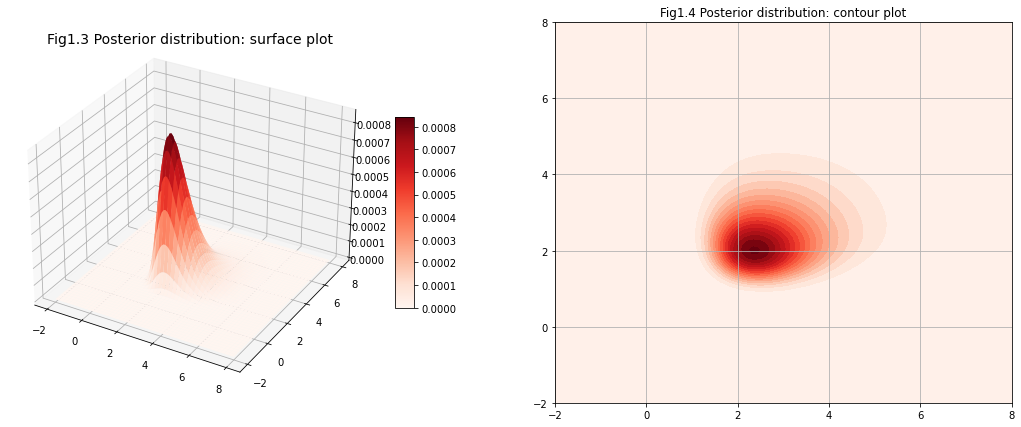

In [224]:
fig = plt.figure(figsize=(9*2, 7))

# surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xx, yy, ZZ, cmap='Reds')
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_title("Fig1.3 Posterior distribution: surface plot", y=1.03, fontsize=14)

# contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contourf(xs, ys, ZZ, 18, cmap='Reds',
            vmin=ZZ.min(), vmax=ZZ.max())
ax.grid()
ax.set_title("Fig1.4 Posterior distribution: contour plot")
                     
plt.show()

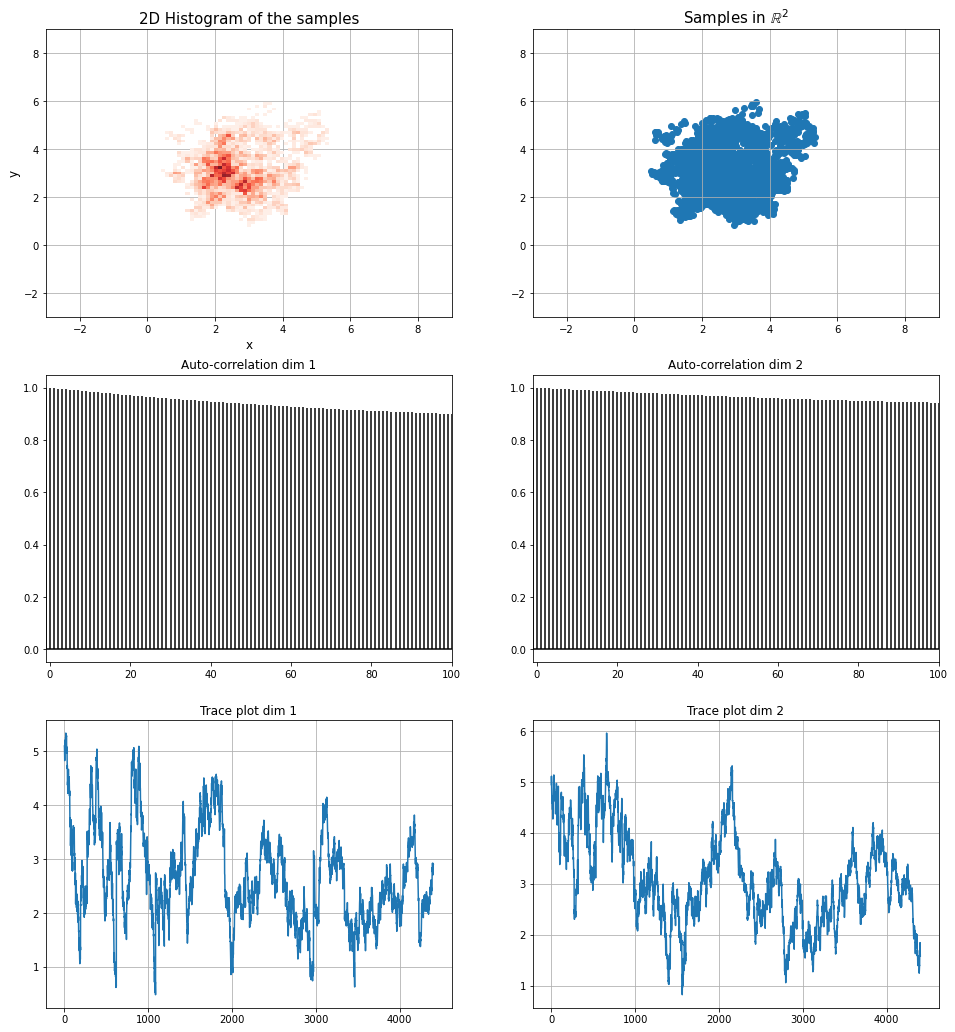

In [225]:
# get the samples
burn_in = int(3*1000 / batch_size)
samples = betas[burn_in:]
xlim, ylim = (-3, 9), (-3, 9)

# get 2-D histogram of the samples
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
H, xs, ys = np.histogram2d(samples[:, 0], samples[:, 1], bins=(xs, ys))
H = H.T

fig, ax = plt.subplots(3, 2, figsize=(2*8, 3*6))
ax = ax.ravel()

ax[0].imshow(H, interpolation='nearest', origin='lower',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap="Reds", vmin=0., alpha=H, zorder=10, aspect='auto')
ax[0].grid()
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_title('2D Histogram of the samples', fontsize=15)

ax[1].scatter(samples[:,0], samples[:,1])
ax[1].set_title('Samples in $\mathbb{R}^2$', fontsize=15)
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()

# auto-correlation plot dim 1
ax[2].acorr(samples[:,0], maxlags=100, color='k')
ax[2].set_xlim(-1,100)
ax[2].set_title("Auto-correlation dim 1")

# auto-correlation plot dim 2
ax[3].acorr(samples[:,1], maxlags=100, color='k')
ax[3].set_xlim(-1,100)
ax[3].set_title("Auto-correlation dim 2")

# traceplot dim 1
ax[4].plot(np.arange(len(samples)), samples[:,0])
ax[4].set_title("Trace plot dim 1")
ax[4].grid()

# traceplot dim 2
ax[5].plot(np.arange(len(samples)), samples[:,1])
ax[5].set_title("Trace plot dim 2")
ax[5].grid()

plt.show()

On observe donc que l'échantillonnage est correct car on reconstruit (plus ou moins) bien les contour de la posterior avec l'histogramme 2D des échantillons. En revanche, l'échantillonnage n'est pas extremement efficace: les échantillons sont très corrélés et les trace-plots montre une certaine tendance globale. 

Ceci était prévisible comme à mesure que l'on échantillonne, les step-sizes diminuent et donc les échantillons sont naturelement plus corrélés car le taux de mélange de la châine de markov induite par les échantillons diminue. On voit donc la nécéssité de pondérer l'importance les échantillons par les step-sizes dans les sommes de Monte-Carlo lorsque l'on approxime des espérances contre la posterior.

#### Predictive distribution and predictions

On peut effectuer des prédictions sur le dataset simple afin de tester la validité de notre algorithme. Afin d'avoir une estimation ponctuelle du paramètre, on prend tout simplement le dernier échantillon $\beta_T$ que l'on a échantillonné, qui devrait normalement être une assez bonne approximation du MAP de la posterior (ou du moins situé dans un des modes de la posterior si cette distribution est multi-modale).

On peut également calculer la predictive distribution et vérifier que l'on a bien une incertitude maximale lorsque l'on est proche de la decision boundary ou loin du training set. Notons que pour calculer la predictive distribution, qui est l'éspérance de la likelihood contre la posterior, on utilise la méthode proposée par l'artcile en pondérant l'importance de chaque échantillon dans la somme de Monte Carlo avec la step-size correspondante.

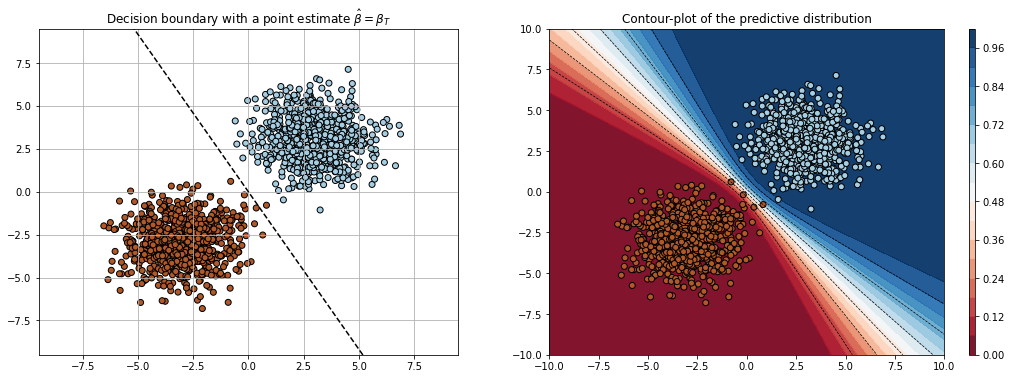

In [226]:
# separating hyperplane
beta = betas[-1]
f = lambda x : (-beta[0]/beta[1]) * x

# contour of the predictive distribution
xs = np.linspace(-10, 10, 100)
ys = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = predictive_MC(X_new=zz, samples=betas, burn_in=burn_in, weights=trackW)
ZZ = ZZ.reshape(xx.shape)

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
x = np.linspace(-10, 10, 10)
ax[0].plot(x, f(x), linestyle='--', color='k')
ax[0].set_ylim(-9.5, 9.5)
ax[0].set_xlim(-9.5, 9.5)
ax[0].set_title("Decision boundary with a point estimate $\\hat{\\beta} = \\beta_T$")
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

Tout d'abord, on observe bien sur la figure de gauche qu'avec un point estimate $\hat{\beta} = \beta_T$ (en prenant le dernier échantillon), on sépare bien les deux classes.  

Puis, sur la figure de droite, on observe exactement le comportement epspéré: on a une incertitude maximale proche de la decision boundary et loin des données d'entrainement. Ceci est utile pour lutter contre l'overfitting: loin des données d'entrainement, il y a apriori peu de chance pour que le modèle classifie correctement les points.

## 1.2 Adaptative Symmetric Random Walk

Dans cette section, on va utiliser une autre méthode d'échantillonnage selon la posterior et comparer les résultats à ceux obtenus précedemment avec la SGLD. Nous allons utiliser une méthode d'échantillonage pur, où nous n'avons pas de phase d'optimisation de la log-posterior: un adaptative symmetric random walk avec une proposal distribution gaussienne. La différence avec un symmetric random walk simple est que l'on apprend la covariance de la proposal distribution au cours des itérations.

### 1.2.1 A brief summary of the method

#### Reminder on symmetric random walk

On rappelle le pricipe du symmetric random walk classique où l'on échantillonne selon une loi cible $\pi$ avec une proposal distribution gaussienne $q_{\Gamma}(\cdot, x) \sim \mathcal{N}(x, \Gamma)$, à chaque itération $t$:

- on génère un candidat $\hat{\theta}_t \sim q_{\Gamma}(\cdot,\theta_{t-1})$,

- on calcule la probabilité d'acceptation du candidat $\alpha(\hat{\theta}_t, \theta_{t-1}) = \mathrm{min}(1, \pi(\hat{\theta}_t) \, / \, \pi(\theta_{t-1})$,

- on génère $u \sim U([0, 1])$ et $\theta_t \leftarrow \hat{\theta}_t$ si $\alpha \geq u$ sinon $\theta_t \leftarrow \theta_{t-1}$.

#### With adaptative covariance

On note $(\mu_t, \Gamma_t)_{t\geq0}$ les paramètres à l'itération $t$. Pour $(\Delta_t)_{t\geq0}$ une suite de gain décroissante vers 0 mais telle que $\sum_t \Delta_t = + \infty$ (pour la convergence de approximation stochastique, comme avec $(\epsilon_t)_{t\geq 0}$ pour la SGLD), à chaque itération $t$:

- on génère $X_t$ selon une étape de symetric random walk classique de proposal $q_{\Gamma}(\cdot,\Gamma)$ (comme décrit ci-dessus),

- on met à jour $\mu$ : $\mu_{t+1} = \mu_t + \Delta_{t+1} \, (\mathrm{X}_{t+1} - \mu_t)$,

- on met à jour $\Gamma$ : $\Gamma_{t+1} = \Gamma_t + \Delta_{t+1} \, \left((\mathrm{X}_{t+1} - \mu_t) \, (\mathrm{X}_{t+1} - \mu_t)^{\top} - \Gamma_{t}\right)$.

On utilisera par la suite $(\Delta_t)_{t\geq0} = (\frac{1}{t^\gamma})_{t\geq0}$ où $\gamma \in (0.5,1]$ sera choisit empiriquement comme pour la SGLD.

#### Why don't we use a simple symmetric random walk ?

Un symmetric random walk classique est très efficace lorsque la distribution est sensiblement gaussienne, i.e lorsque les sublevel sets de la densité cible sont ellispoïdal.  

Ici, les plots précédents montrent que les sub-level sets de la posterior distribution $p(\beta|X,y)$ sont assez anisotropes et étirés selon une certane direction: la prior de laplace entaîne une queue lourde pour la posterior.  

Pour pouvoir échantillonner efficacement dans la queue de la distribution, on devrait utiliser une proposal distribution de grande variance, ce qui entrainerait beacoup de rejet et donc un algorithme plus long pour obtenir assez d'échantillons pour approximer des predictive distributions.

L'adaptative symmetric random walk est alors utilisé pour pouvoir échantillonner dans la queue de la distribution tout en évitant d'avoir un taux d'acceptation trop faible  car la covariance de la proposal distribution est apprise au cours des itérations afin de s'adapter aux différentes zones dans lesquelles on échantillonne. 

#### What should we expect w.r.t SGLD ?

Comme on utilise ici une méthode MCMC classique, chaque itération nécessite de manipuler tout le training set: on doit calculer la probabilité d'acceptation  des candidats à chacune des itérations, qui est un rapport de posterior distribution donc qui nécessite tous les training examples (pas de calculs par batch). On devrait donc avoir un échantilonnage plus lent, surtout lorsque le dataset est grand. Il sera donc interessant de comparer les running times, surtout sur de grand datasets.

De plus, comme on utilise ici une méthode purement axé échantillonage (et pas optimisation), on devrait avoir un échantillonnage de meilleur qualité (échantillons moins corrélés, trace-plots plus uniformes). 

### 1.2.2 Implementation

In [277]:
def srwMH(n_samples, cov, init_sample, target=target, dim=2):
    '''
    Symetric Random Walk Hasting Metropolis algorithm.
    Parameters:
      n_samples: int, number of samples to generate
      cov: np.array, covariance of the proposal distribution
      init_sample: np.array, initial sample
      target: callable, target distrbution
    Returns:
      samples: np.array, generated samples
      accept_ratio: float, acceptance ratio (#{accepted_candidates} / #{number_iterations})
      alphas: np.array, acceptance probability at each step
    '''
    start = time.time()
    samples = np.vstack((init_sample, np.zeros((n_samples, dim))))
    alphas = np.zeros(n_samples)
    accept_bools = np.zeros(n_samples)
    
    for ii in tqdm(range(n_samples)):
        
        # draw a candidate
        current = samples[ii]
        proposal = multivariate_normal(mean=current, cov=cov)
        cand = proposal.rvs(size=1)
        
        # compute acceptance ratio
        alpha = min(1, target(cand) / target(current)) if target(current)>0 else 1
        alphas[ii] = alpha
        
        # accept with proba alpha
        u = np.random.rand()
        accept_bool = (alpha > u)
        accept_bools[ii] = accept_bool
        if accept_bool:
            samples[ii+1] = cand     # accept candidate
        else:
            samples[ii+1] = current   # reject candidate
                                
    # compute acceptance ratio
    accept_ratio = np.mean(accept_bools)
    
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    return samples, accept_ratio, alphas

In [272]:
def adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, c=1, target=target, dim=2):
    '''
    Adaptive symetric Random Walk Hasting Metropolis algorithm.
    Parameters:
      n_samples: int, number of samples to generate
      init_mu: np.array, initial mean of the proposal distribution
      init_cov: np.array, initial covariance of the proposal distribution
      init_sample: np.array, initial sample
      gamma: float, controls the decreasing speed of the step size
      c: float, weight to ponderate proposal covariance at each iteration (advanced setting, keep it to 1 in general)
      target: callable, target distrbution
    Returns:
      samples: np.array, generated samples
      accept_ratio: float, acceptance ratio (#{accepted_candidates} / #{number_iterations})
      alphas: np.array, acceptance probability at each step
    '''
    start = time.time()
    samples = np.vstack((init_sample, np.zeros((n_samples, dim))))
    alphas = np.zeros(n_samples)
    accept_bools = np.zeros(n_samples)
    
    # initialize parameters
    mus = np.vstack((init_mu, np.zeros((n_samples, dim))))
    covs = np.vstack((init_cov[None, :], np.zeros((n_samples, dim, dim))))
    
    for ii in tqdm(range(n_samples)):
        
        # draw a candidate
        current = samples[ii]
        proposal = multivariate_normal(mean=current, cov=c*covs[ii])
        cand = proposal.rvs(size=1)
        
        # compute acceptance ratio
        alpha = min(1, target(cand) / target(current)) if target(current)>0 else 1
        alphas[ii] = alpha
        
        # accept with proba alpha
        u = np.random.rand()
        accept_bool = (alpha > u)
        accept_bools[ii] = accept_bool
        if accept_bool:
            samples[ii+1] = cand     # accept candidate
        else:
            samples[ii+1] = current   # reject candidate
                                
        # update parameters
        mus[ii+1] = mus[ii] + (1/((ii+1)**gamma)) * (samples[ii+1] - mus[ii])
        covs[ii+1] = covs[ii] + (1/((ii+1)**gamma)) * ((samples[ii+1] - mus[ii]) @ (samples[ii+1] - mus[ii]).T - covs[ii]) + (1/((ii+1)**(gamma))) * np.eye(dim)
            
    # compute acceptance ratio
    accept_ratio = np.mean(accept_bools)
    
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    return samples, accept_ratio, alphas

### 1.2.3 Application on a toy dataset

On conserve ici le même dataset simple dans $\mathbb{R}^2$ que précedemment afin de tester notre implémentation. 

#### Sampling

On échantillonne afin d'avoir un taux d'acceptance autour de 25%, afin d'explorer efficacement le support de la posterior.

In [286]:
# target distribution
target = lambda beta: np.exp(log_post_laplace(beta, X, y))

n_samples = 5000
init_cov =  1 * np.eye(2)
init_mu = np.asarray([0, 0])
init_sample = np.ones(2)
gamma = .6
#cov = np.eye(2)

samples, accept_ratio, alphas = adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma)
#samples, accept_ratio, alphas = srwMH(n_samples, cov, init_sample)
print("Acceptance ratio: {}".format(accept_ratio))

100%|██████████| 5000/5000 [00:01<00:00, 2654.60it/s]


Done in 1.89 s.
Acceptance ratio: 0.326


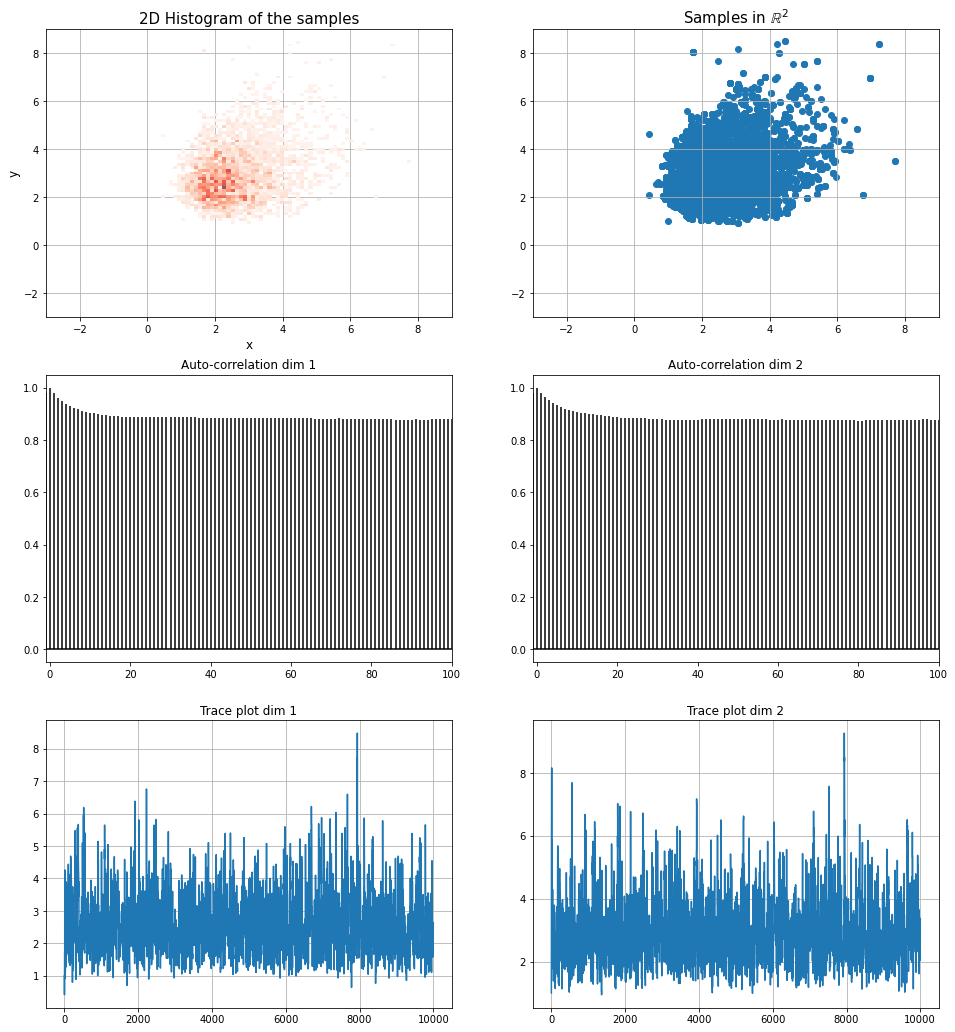

In [285]:
# get the samples
xlim, ylim = (-3, 9), (-3, 9)

# get 2-D histogram of the samples
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
H, xs, ys = np.histogram2d(samples[:, 0], samples[:, 1], bins=(xs, ys))
H = H.T

fig, ax = plt.subplots(3, 2, figsize=(2*8, 3*6))
ax = ax.ravel()

ax[0].imshow(H, interpolation='nearest', origin='lower',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap="Reds", vmin=0., alpha=H, zorder=10, aspect='auto')
ax[0].grid()
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_title('2D Histogram of the samples', fontsize=15)

ax[1].scatter(samples[:,0], samples[:,1])
ax[1].set_title('Samples in $\mathbb{R}^2$', fontsize=15)
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()

# auto-correlation plot dim 1
ax[2].acorr(samples[:,0], maxlags=100, color='k')
ax[2].set_xlim(-1,100)
ax[2].set_title("Auto-correlation dim 1")

# auto-correlation plot dim 2
ax[3].acorr(samples[:,1], maxlags=100, color='k')
ax[3].set_xlim(-1,100)
ax[3].set_title("Auto-correlation dim 2")

# traceplot dim 1
ax[4].plot(np.arange(len(samples)), samples[:,0])
ax[4].set_title("Trace plot dim 1")
ax[4].grid()

# traceplot dim 2
ax[5].plot(np.arange(len(samples)), samples[:,1])
ax[5].set_title("Trace plot dim 2")
ax[5].grid()

plt.show()